# Two-level system tutorial

## Import

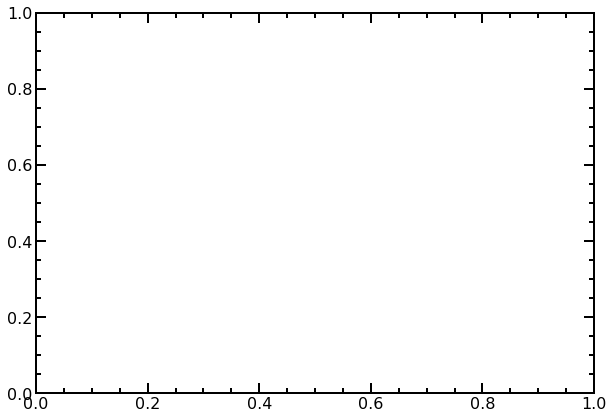

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
import plotting_settings
import scipy.linalg

## Bloch sphere

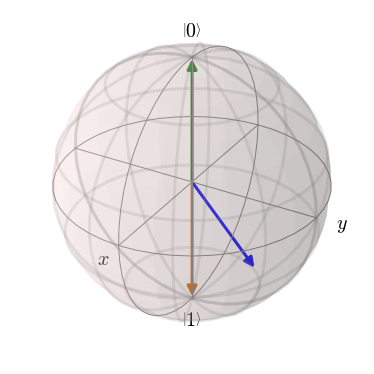

In [2]:
psi0 = basis(2,0)
psi1 = basis(2,1)
a=3
b=3j+2
psi = (a*psi0 + b*psi1)/np.sqrt(abs(a)**2+abs(b)**2)
b = Bloch()
b.add_states([psi0,psi1,psi])
b.make_sphere()

## Driving two-level system
Here, we define the two-level system via the Hamiltonian $$H=\frac{1}{2}\omega_a\sigma_Z$$ and the driving term 
$$H_d= g\cos(\omega_d t)\sigma_X$$
We can either solve the Schrodinger equation directly or use RWA to get the Hamiltonian in the rotating frame.

First, we simulate the system in the lab frame. Note the fast oscillation which is due to fast rotation in the lab frame around Z.

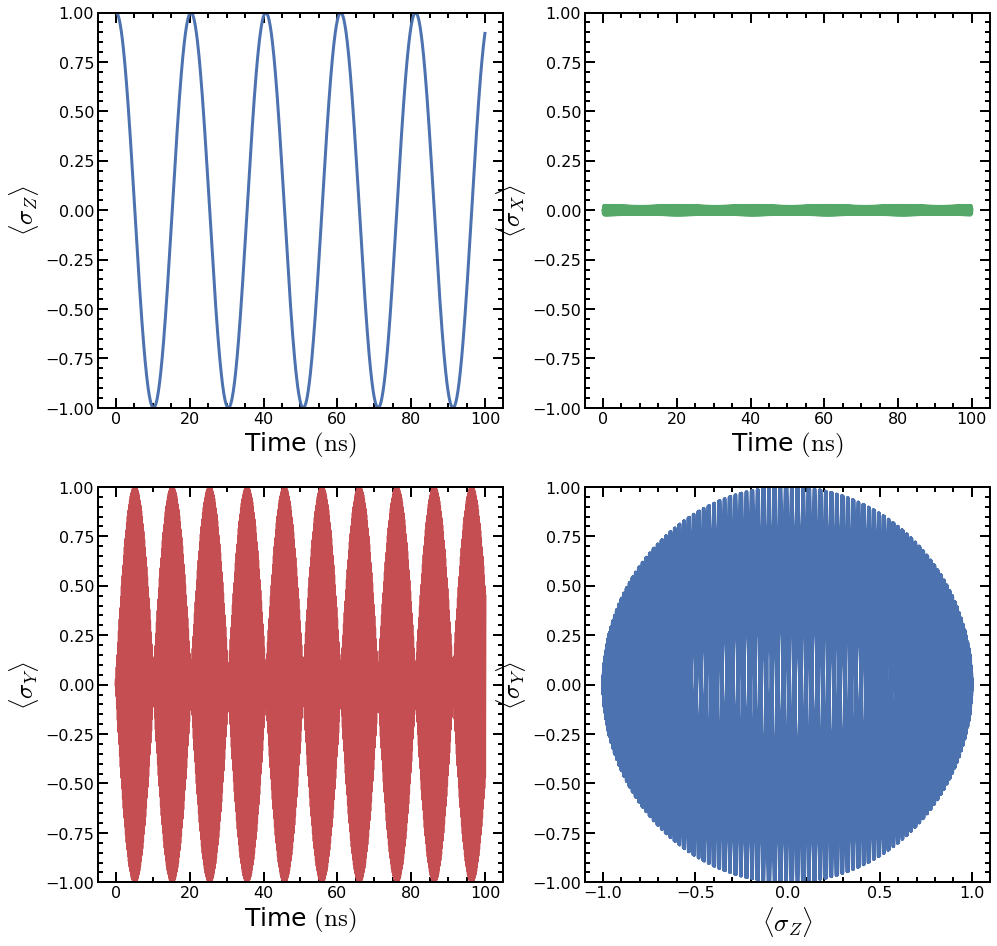

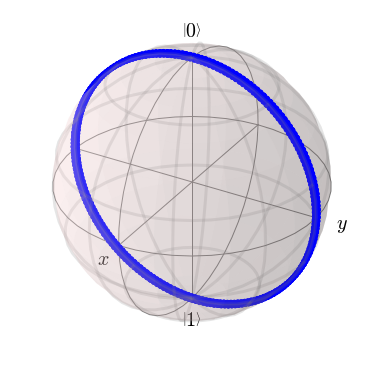

In [3]:
atom_freq = 5 #GHz
drive_freq = 5 #GHz
coupl_const = 0.05 #GHz
H0 = 2*np.pi*0.5*atom_freq*sigmaz()
H1 = 2*np.pi*coupl_const*sigmax()
tlist = np.linspace(0,int(100),1001) #ns
def time_dependent_term(t, **kargs):
    nu_d = kargs['omega_d']
    two_pi_t = 2 * np.pi * t
    return np.cos(nu_d * two_pi_t)
H = [H0,[H1, time_dependent_term(t=tlist, omega_d = drive_freq)]]
output = mesolve(H, rho0=basis(2,0), tlist=tlist, c_ops=[], e_ops=[])
sz = np.real(expect(sigmaz(),output.states))
sx = np.real(expect(sigmax(),output.states))
sy = np.real(expect(sigmay(),output.states))
fig, axes = plt.subplots(2,2, figsize = [16,16])
axes[0,0].plot(tlist,sz)
axes[0,0].set_ylim([-1,1])
axes[0,0].set_xlabel(r'Time $\mathrm{(ns)}$')
axes[0,0].set_ylabel(r'$\langle \sigma_Z \rangle$')
axes[0,1].plot(tlist,sx, color = 'C1')
axes[0,1].set_ylim([-1,1])
axes[0,1].set_xlabel(r'Time $\mathrm{(ns)}$')
axes[0,1].set_ylabel(r'$\langle \sigma_X \rangle$')
axes[1,0].plot(tlist,sy, color = 'C2')
axes[1,0].set_ylim([-1,1])
axes[1,0].set_xlabel(r'Time $\mathrm{(ns)}$')
axes[1,0].set_ylabel(r'$\langle \sigma_Y \rangle$')
axes[1,1].plot(sz,sy)
axes[1,1].set_ylim([-1,1])
axes[1,1].set_xlabel(r'$\langle \sigma_Z \rangle$')
axes[1,1].set_ylabel(r'$\langle \sigma_Y \rangle$')

b = Bloch()
b.add_points([sx, sy, sz], meth ='s')
b.make_sphere()

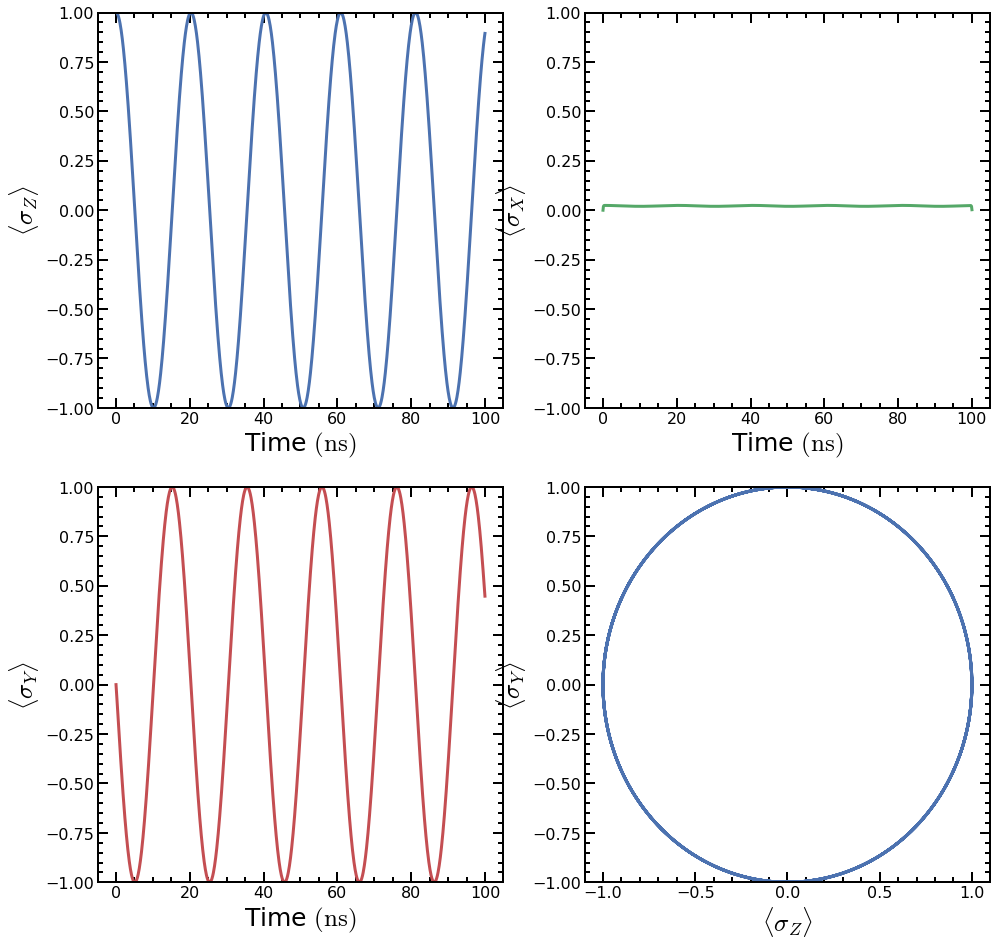

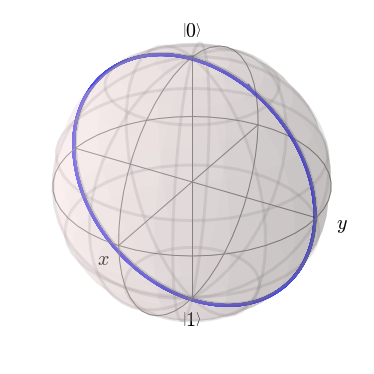

In [4]:
# Transform back to the rotating frame
sz = np.real(expect(sigmaz(),output.states))
sx = np.real(expect(sigmax(),output.states))
sy = np.real(expect(sigmay(),output.states))
fig, axes = plt.subplots(2,2, figsize = [16,16])
axes[0,0].plot(tlist,sz)
axes[0,0].set_ylim([-1,1])
axes[0,0].set_xlabel(r'Time $\mathrm{(ns)}$')
axes[0,0].set_ylabel(r'$\langle \sigma_Z \rangle$')
axes[0,1].plot(tlist,sx*np.cos(2*np.pi*drive_freq*tlist), color = 'C1')
axes[0,1].set_ylim([-1,1])
axes[0,1].set_xlabel(r'Time $\mathrm{(ns)}$')
axes[0,1].set_ylabel(r'$\langle \sigma_X \rangle$')
axes[1,0].plot(tlist,sy*np.cos(2*np.pi*drive_freq*tlist), color = 'C2')
axes[1,0].set_ylim([-1,1])
axes[1,0].set_xlabel(r'Time $\mathrm{(ns)}$')
axes[1,0].set_ylabel(r'$\langle \sigma_Y \rangle$')
axes[1,1].plot(sz,sy*np.cos(2*np.pi*drive_freq*tlist))
axes[1,1].set_ylim([-1,1])
axes[1,1].set_xlabel(r'$\langle \sigma_Z \rangle$')
axes[1,1].set_ylabel(r'$\langle \sigma_Y \rangle$')

b = Bloch()
b.add_points([sx*np.cos(2*np.pi*drive_freq*tlist), sy*np.cos(2*np.pi*drive_freq*tlist), sz], meth ='l')
b.make_sphere()

### Using RWA

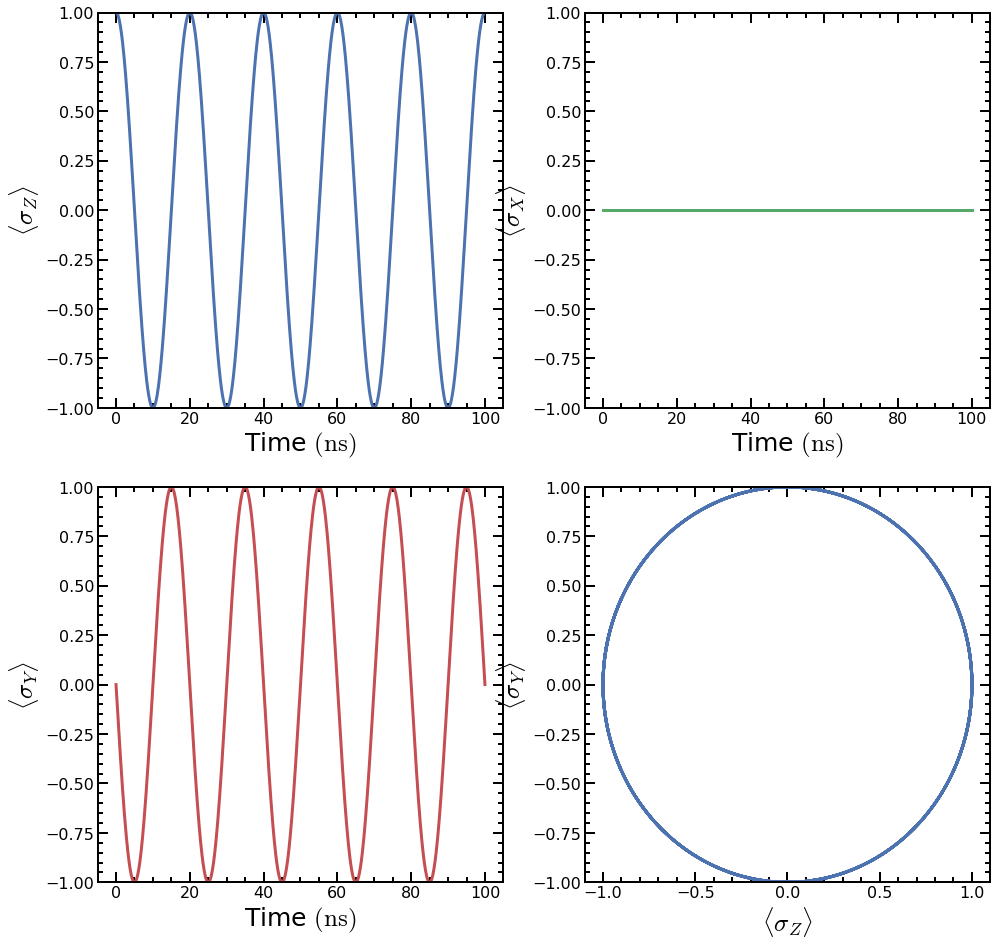

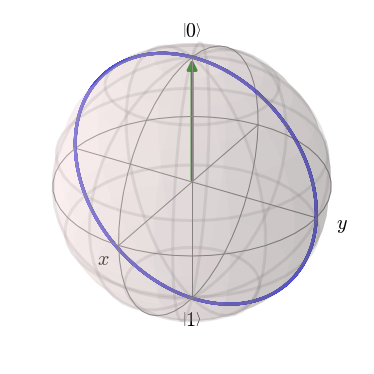

In [5]:
#Using RWA
atom_freq = 5 #GHz
drive_freq = 5 #GHz
coupl_const = 0.05 #GHz
# psi_ini = basis(2,0) - 1j*basis(2,1)
psi_ini = basis(2,0)
psi_ini = psi_ini.unit()
H = 2*np.pi*0.5*(atom_freq-drive_freq)*sigmaz() + 2*np.pi*0.5*coupl_const*sigmax()
output = mesolve(H, rho0=psi_ini,tlist = tlist, c_ops=[], e_ops=[sigmax(), sigmay(),sigmaz()])
sx, sy, sz = output.expect[:]
fig, axes = plt.subplots(2,2, figsize = [16,16])
axes[0,0].plot(tlist,sz)
axes[0,0].set_ylim([-1,1])
axes[0,0].set_xlabel(r'Time $\mathrm{(ns)}$')
axes[0,0].set_ylabel(r'$\langle \sigma_Z \rangle$')
axes[0,1].plot(tlist,sx, color = 'C1')
axes[0,1].set_ylim([-1,1])
axes[0,1].set_xlabel(r'Time $\mathrm{(ns)}$')
axes[0,1].set_ylabel(r'$\langle \sigma_X \rangle$')
axes[1,0].plot(tlist,sy, color = 'C2')
axes[1,0].set_ylim([-1,1])
axes[1,0].set_xlabel(r'Time $\mathrm{(ns)}$')
axes[1,0].set_ylabel(r'$\langle \sigma_Y \rangle$')
axes[1,1].plot(sz,sy)
axes[1,1].set_ylim([-1,1])
axes[1,1].set_xlabel(r'$\langle \sigma_Z \rangle$')
axes[1,1].set_ylabel(r'$\langle \sigma_Y \rangle$')

b = Bloch()
b.add_points([sx, sy, sz], meth='l')
b.add_states(psi_ini)
b.make_sphere()

### Pulse shape
Above we assume a constant drive. Here, we assume that the drive can be shaped by using a modulated pulse. We can redefine the drive Hamiltonian as a product of the pulse and the carrier tone. We use the pulse shapes functions developed by Konstantin Nesterov.

In [6]:
atom_freq = 0.5 #GHz
drive_freq = 0.5 #GHz
coupl_const = 1 #normalized, 1 = 2pi pulse
H0 = 0.5*atom_freq*sigmaz()
H1 = coupl_const*sigmax()
sigma = 0.25

T_start = 0
T_gate = 20
shape = 'gauss'
drag = False
drag_coeff = 0.1
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
U_t = gates.evolution_operator_microwave(H0,H1, t_points=t_points,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=drive_freq)

In [7]:
ini_state = basis(2,0)
fin_state = basis(2,0)
trans_prob = gates.prob_transition(U_t, ini_state, fin_state)
plt.plot(t_points, trans_prob)
plt.xlabel('Time (ns)')
plt.ylabel(r'$P_{|0\rangle}$')
U_ideal = qeye(2)
U_real = U_t[-1]
op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidelity = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(fidelity)

TypeError: prob_transition() missing 1 required positional argument: 'final_state'

### Three level system

In [8]:
#Now look at three level system
wa = 5
anharmonicity = -0.2
w0 = 0
w1 = wa
w2 = 2*wa+anharmonicity
p1 = basis(3,1)*basis(3,1).dag()
p2 = basis(3,2)*basis(3,2).dag()
H0 = w1*p1 + w2*p2
a = destroy(3)
wd = wa
coupl_const = 1 #normalized to 2pi pulse
H1 = coupl_const*(a+a.dag())

T_start = 0
T_gate = 20
shape = 'gauss'
drag = True
drag_coeff = 0.5
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
U_t = gates.evolution_operator_microwave(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=wd)

ini_state = basis(3,0)
trans_prob_0 = gates.prob_transition(U_t, ini_state, basis(3,0))
trans_prob_1 = gates.prob_transition(U_t, ini_state, basis(3,1))
trans_prob_2 = gates.prob_transition(U_t, ini_state, basis(3,2))
plt.plot(t_points, trans_prob_0)
plt.plot(t_points, trans_prob_1)
plt.plot(t_points, trans_prob_2)
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')

#Truncated to lowest 2 levels
P = basis(3,0)*basis(3,0).dag() + basis(3,1)*basis(3,1).dag()
U_real = P*U_t[-1]*P
U_ideal = P*qeye(3)*P
op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidelity = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(fidelity*100)

TypeError: prob_transition() missing 1 required positional argument: 'final_state'

# Coupled system

Text(0, 0.5, 'Transition freq')

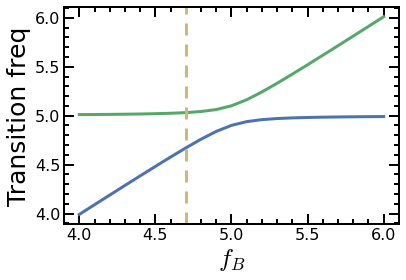

In [9]:
ZI = tensor(sigmaz(),qeye(2))
XI = tensor(sigmax(),qeye(2))
YI = tensor(sigmay(),qeye(2))
IZ = tensor(qeye(2), sigmaz())
IX = tensor(qeye(2), sigmax())
IY = tensor(qeye(2), sigmay())
XX = tensor(sigmax(), sigmax())
def coupled_tls_hamiltonian(wa,wb,g):
    return wa*ZI/2 + wb*IZ/2 + g*IX*XI

freq_a = 5
freq_b = np.linspace(4,6,21)
coupling = 0.1
energies = np.zeros((len(freq_b), 4))
for idx, wb in enumerate(freq_b):
    energies[idx,:] = coupled_tls_hamiltonian(freq_a,wb,coupling).eigenenergies()
for idy in range(1,3):
    plt.plot(freq_b, energies[:,idy]-energies[:,0])
plt.axvline(x=4.7, color='C4', linestyle='--')
plt.xlabel(r'$f_B$')
plt.ylabel('Transition freq')

Text(0, 0.5, '$\\delta f_{00-10}$')

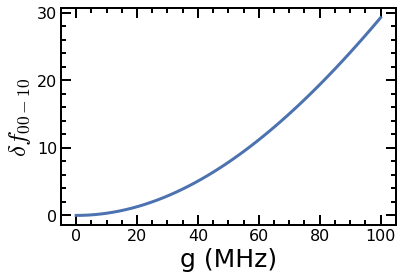

In [10]:
freq_a = 5
freq_b = 4.7
coupling = np.linspace(0,0.1)
energies = np.zeros((len(coupling), 4))
for idx, g in enumerate(coupling):
    energies[idx,:] = coupled_tls_hamiltonian(freq_a,freq_b,g).eigenenergies()
trans_freq = energies[:,1]   - energies[:,0]
trans_freq = abs(trans_freq - np.max(trans_freq))
plt.plot(coupling*1e3, trans_freq*1e3)
plt.xlabel('g (MHz)')
plt.ylabel(r'$\delta f_{00-10}$')

## Cross resonance dynamics

In [222]:
#Hamiltonian (undriven)
freq_a = 5 
freq_b = 4.7 
g = 0.1 
coupl_const = 1

# A: 00-10, 01-11, B: 00-01, 10-11 
H0 = 0.5*(freq_a*ZI+freq_b*IZ) + g*XX
eig_energies = H0.eigenenergies()
drive_freq = eig_energies[1]-eig_energies[0] #qubit b
H1 = 5*coupl_const*(XI+0*IX)
# H_local = 1*(IX)
#Gate
T_start = 0
T_gate = 2000
shape = 'square'
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

Text(0, 0.5, '$P$')

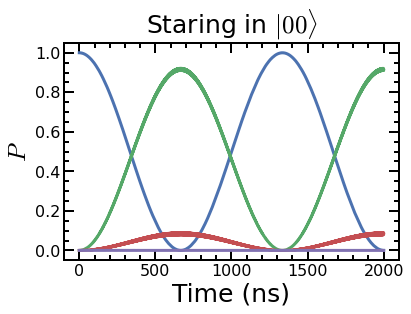

In [282]:
#Using propagator
H_dum = tensor(qeye(2), qeye(2))
U_t = gates.evolution_operator_microwave(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=drive_freq)
U_nothing = gates.evolution_operator_microwave(-H0,H_dum, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=drive_freq)
state_00 = tensor(basis(2,0),basis(2,0))
state_01 = tensor(basis(2,0),basis(2,1))
state_10 = tensor(basis(2,1),basis(2,0))
state_11 = tensor(basis(2,1),basis(2,1))

trans_prob_00_00 = expect(state_00 * state_00.dag(),U_t*state_00)
trans_prob_00_01 = expect(state_01 * state_01.dag(),U_t*state_00)
trans_prob_00_10 = expect(state_10 * state_10.dag(),U_t*state_00)
trans_prob_00_11 = expect(state_11 * state_11.dag(),U_t*state_00)

plt.plot(t_points, trans_prob_00_00)
plt.plot(t_points, trans_prob_00_01)
plt.plot(t_points, trans_prob_00_10)
plt.plot(t_points, trans_prob_00_11)
plt.title(r'Staring in $|00\rangle$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')

Text(0, 0.5, '$P$')

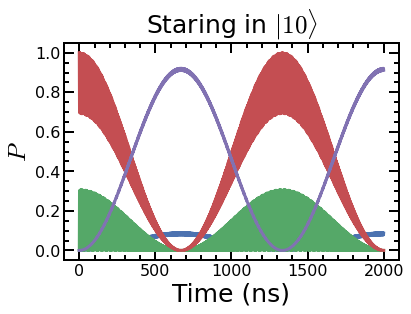

In [224]:
trans_prob_10_00 = expect(state_00 * state_00.dag(),U_t*state_10)
trans_prob_10_01 = expect(state_01 * state_01.dag(),U_t*state_10)
trans_prob_10_10 = expect(state_10 * state_10.dag(),U_t*state_10)
trans_prob_10_11 = expect(state_11 * state_11.dag(),U_t*state_10)
plt.plot(t_points, trans_prob_10_00)
plt.plot(t_points, trans_prob_10_01)
plt.plot(t_points, trans_prob_10_10)
plt.plot(t_points, trans_prob_10_11)
plt.title(r'Staring in $|10\rangle$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')

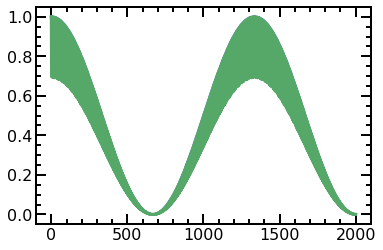

In [225]:
#Cross resonance time?
plt.plot(t_points, trans_prob_00_00)
plt.plot(t_points, trans_prob_10_10)

709


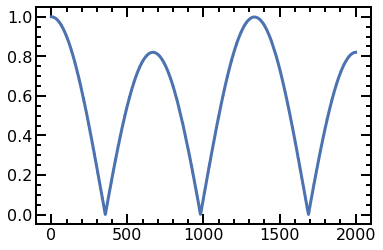

In [293]:
s0 = U_nothing*U_t*state_00
s1 = U_nothing*U_t*state_10
R = np.sqrt((expect(IX,s0)+expect(IX,s1))**2 
           +(expect(IY,s0)+expect(IY,s1))**2
           +(expect(IZ,s0)+expect(IZ,s1))**2
           )/2
plt.plot(t_points, R)
print (np.argmin(R[0:1000]))

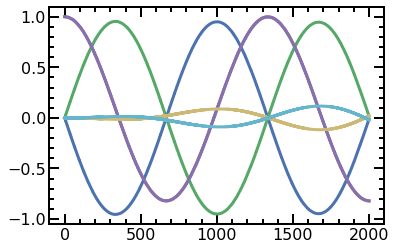

In [289]:
plt.plot(t_points, expect(IY,s0))
plt.plot(t_points, expect(IY,s1))
plt.plot(t_points, expect(IZ,s0))
plt.plot(t_points, expect(IZ,s1))
plt.plot(t_points, expect(IX,s0))
plt.plot(t_points, expect(IX,s1))

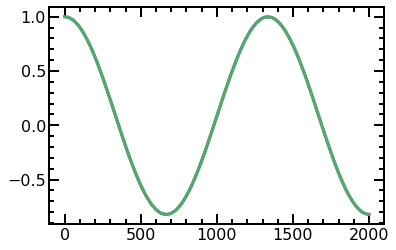

In [228]:
plt.plot(t_points, expect(IZ,s0))
plt.plot(t_points, expect(IZ,s1))

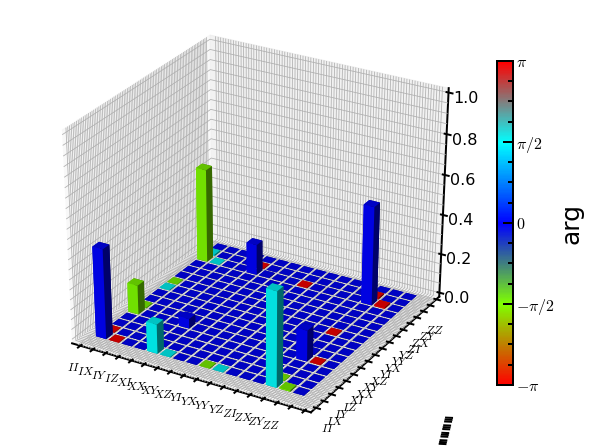

In [294]:
N = 2
U_ZX = U_nothing[709]*U_t[709]
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()] for i in range(N)]
U_rho = spre(U_ZX) * spost(U_ZX.dag())
chi = qpt(U_rho, op_basis)
op_label = [["$I$", "$X$", "$Y$", "$Z$"] for i in range(N)]
fig, ax = qpt_plot_combined(chi, op_label)

<ipython-input-280-3142f50b409e>:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_ZX_ideal = tensor(rz(np.pi), rx(np.pi/2))


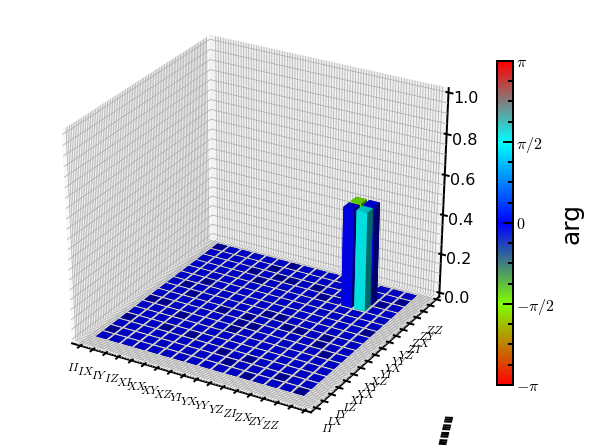

In [280]:
#Ideal case
U_ZX_ideal = tensor(rz(np.pi), rx(np.pi/2))
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()] for i in range(N)]
U_rho = spre(U_ZX_ideal) * spost(U_ZX_ideal.dag())
chi = qpt(U_rho, op_basis)
op_label = [["$I$", "$X$", "$Y$", "$Z$"] for i in range(N)]
fig, ax = qpt_plot_combined(chi, op_label)

In [231]:
H_xdrive = coupl_const*(IX)
Ux_t = gates.evolution_operator_microwave(H0,H_xdrive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=drive_freq)
Ux_nothing = gates.evolution_operator_microwave(-H0,H_dum, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=drive_freq)

1989


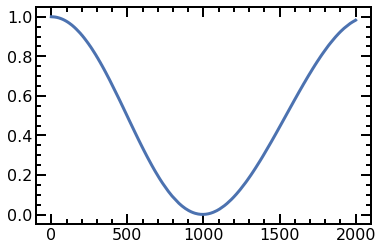

In [238]:
trans_prob_00_00 = expect(state_00 * state_00.dag(),Ux_t*state_00)
trans_prob_00_01 = expect(state_01 * state_01.dag(),Ux_t*state_00)
trans_prob_00_10 = expect(state_10 * state_10.dag(),Ux_t*state_00)
trans_prob_00_11 = expect(state_11 * state_11.dag(),Ux_t*state_00)

plt.plot(t_points, trans_prob_00_00)
print (np.argmin(trans_prob_00_00))

In [243]:
H_zdrive = coupl_const*(IZ)
Uz_t = gates.evolution_operator_microwave(H0,H_zdrive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=drive_freq)
Uz_nothing = gates.evolution_operator_microwave(-H0,H_dum, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=drive_freq)

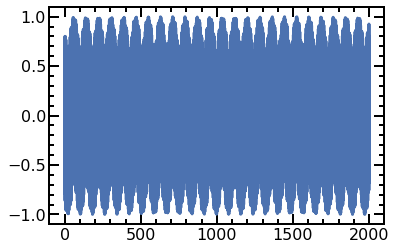

In [247]:
ini_state = (state_00 +state_01).unit()
probe = expect(IY,Uz_t*ini_state)
plt.plot(t_points, probe)

<ipython-input-296-9a7de55055f6>:3: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_IZ2 = tensor(qeye(2), rz(np.pi/2))
<ipython-input-296-9a7de55055f6>:4: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_IX2 = tensor(qeye(2), rx(np.pi/2))


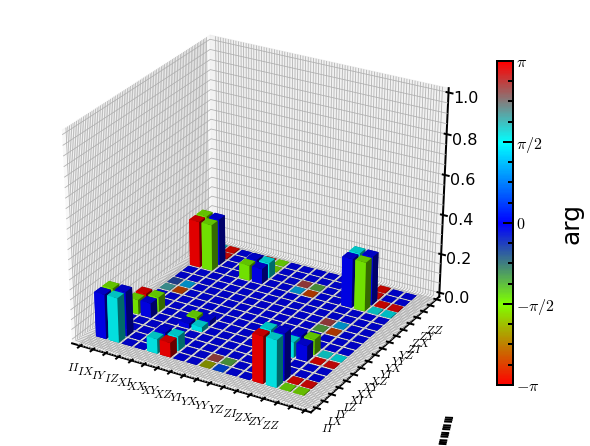

In [296]:
U_IX2 = Ux_nothing[994]*Ux_t[994]
# IZ2 = tensor(qeye(2), rz(np.pi/2))
U_IZ2 = tensor(qeye(2), rz(np.pi/2))
U_IX2 = tensor(qeye(2), rx(np.pi/2))
U_CNOT = U_IX2 * U_ZX 

op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()] for i in range(N)]
U_rho = spre(U_CNOT) * spost(U_CNOT.dag())
chi = qpt(U_rho, op_basis)
op_label = [["$I$", "$X$", "$Y$", "$Z$"] for i in range(N)]
fig, ax = qpt_plot_combined(chi, op_label)